In [1]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
images_folder = Path("dog-breed-identification")
train_folder = images_folder / "train_subset"
test_folder = images_folder / "test"

In [3]:
image_shape = (224, 224, 3)
full_dataset = image_dataset_from_directory(train_folder, batch_size=32, label_mode='categorical', image_size=(image_shape[0], image_shape[1]))

Found 839 files belonging to 10 classes.


In [4]:
full_dataset.shuffle(850, seed=1)

validation_dataset = full_dataset.take(5)
test_dataset = full_dataset.skip(5).take(10)
train_dataset = full_dataset.skip(15)

(32, 224, 224, 3)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


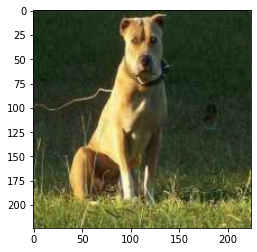

In [5]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataset.take(1)))
print(images.shape)
print(labels[0])
plt.imshow(images[0].numpy().astype("uint8"))

In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=image_shape)

In [7]:
pretrained_model.summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

In [9]:
pretrained_model.trainable = False

model = Sequential([
    layers.Lambda(preprocess_input, input_shape=image_shape),
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
    optimizer = 'adam',
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True
)

In [14]:
history = model.fit(
    train_dataset.cache(),
    epochs=20,
    validation_data=validation_dataset.cache(),
    callbacks=[early_stopping]
)

Epoch 1/20
12/12 [==============================] - 75s 6s/step - loss: 1.8816 - accuracy: 0.3872 - val_loss: 1.0493 - val_accuracy: 0.8062
Epoch 2/20
12/12 [==============================] - 66s 5s/step - loss: 0.6904 - accuracy: 0.9025 - val_loss: 0.4690 - val_accuracy: 0.9125
Epoch 3/20
12/12 [==============================] - 70s 6s/step - loss: 0.3172 - accuracy: 0.9610 - val_loss: 0.2786 - val_accuracy: 0.9625
Epoch 4/20
12/12 [==============================] - 64s 5s/step - loss: 0.1969 - accuracy: 0.9749 - val_loss: 0.2120 - val_accuracy: 0.9625
Epoch 5/20
12/12 [==============================] - 64s 5s/step - loss: 0.1449 - accuracy: 0.9833 - val_loss: 0.1800 - val_accuracy: 0.9688
Epoch 6/20
12/12 [==============================] - 64s 5s/step - loss: 0.1144 - accuracy: 0.9889 - val_loss: 0.1605 - val_accuracy: 0.9688
Epoch 7/20
12/12 [==============================] - 69s 6s/step - loss: 0.0937 - accuracy: 0.9944 - val_loss: 0.1484 - val_accuracy: 0.9688
Epoch 8/20
12/12 [==

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

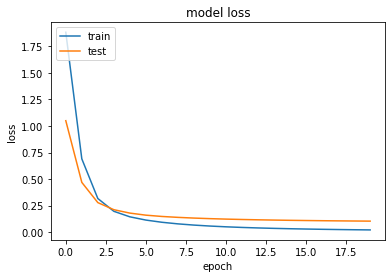

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
prediction_result = model.predict(test_dataset)

array([[2.1647536e-03, 2.2342587e-03, 1.6271753e-02, ..., 1.7429879e-03,
        6.3789999e-03, 1.4579190e-03],
       [2.8605605e-04, 2.5896770e-03, 3.9545461e-03, ..., 9.8662716e-01,
        1.4722334e-04, 9.7826170e-04],
       [3.6185915e-03, 2.8353892e-04, 9.8927593e-01, ..., 9.3905488e-05,
        1.5177975e-04, 7.0992231e-05],
       ...,
       [2.4803482e-01, 8.0230549e-02, 5.4175094e-02, ..., 1.6590233e-03,
        7.8149419e-03, 1.8239176e-02],
       [3.0107761e-03, 1.0276561e-02, 3.7922026e-03, ..., 9.7667092e-01,
        1.3280702e-03, 8.6165301e-04],
       [2.6738308e-02, 1.0429480e-03, 9.1689806e-03, ..., 8.8541536e-04,
        5.8782455e-03, 3.5650488e-03]], dtype=float32)

In [29]:
cached_test_dataset = test_dataset.cache()

In [30]:
roc_auc = tf.keras.metrics.AUC(curve='ROC')

dataset_labels = np.concatenate([y for x, y in cached_test_dataset], axis=0)
roc_auc.update_state(dataset_labels, model.predict(cached_test_dataset))

In [31]:
roc_auc.result().numpy()

0.9970427

In [15]:
model.save("dog_breed_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: transfer_learning.model\assets


In [6]:
model2 = tf.keras.models.load_model("dog_breed_model")

In [11]:
for folder in train_folder.glob("*"):
    (images_folder / "external" / folder.stem).mkdir()

In [26]:
# test on external images for correct predictions

test_images_external = image_dataset_from_directory(images_folder / "external", batch_size=1, label_mode='categorical', image_size=(image_shape[0], image_shape[1]))

Found 12 files belonging to 10 classes.


tf.Tensor([[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 10), dtype=float32)


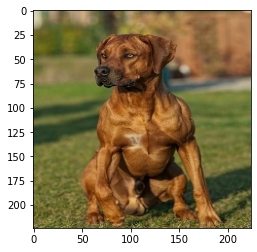

In [27]:
images, labels = next(iter(test_images_external.take(1)))
print(labels)
plt.imshow(images[0].numpy().astype("uint8"))

predicted: 1 true: 1
predicted: 2 true: 2
predicted: 1 true: 1
predicted: 1 true: 1
predicted: 2 true: 3
probabilities: [[1.9153379e-02 5.5585062e-04 6.9078803e-01 1.4423062e-01 5.5403695e-03
  2.5333727e-02 1.2370368e-02 4.8099749e-02 1.4687773e-02 3.9240055e-02]]


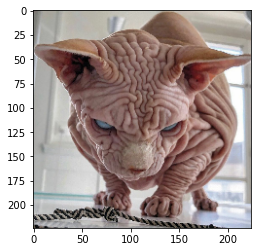

predicted: 2 true: 2
predicted: 2 true: 2
predicted: 2 true: 2
predicted: 6 true: 6
predicted: 1 true: 1
predicted: 6 true: 6
predicted: 6 true: 6


In [31]:
for image, label in test_images_external:
    prediction = model2.predict(image)
    class_pred = np.argmax(prediction)
    class_true = np.argmax(label)
    print(f"predicted: {class_pred} true: {class_true}")
    if class_pred != class_true:
        print(f"probabilities: {prediction}")
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.show()